# Near to far field transformation

To run this notebook from your browser, click [this link](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FNear2Far.ipynb).

This tutorial will show you how to solve for electromagnetic fields far away from your structure using field information stored on a nearby surface.

This technique is called a 'near field to far field transformation' and is very useful for reducing the simulation size needed for structures involving lots of empty space.

As an example, we will simulate a simple zone plate lens with a very thin domain size to get the transmitted fields measured just above the structure.  Then, we'll show how to use the [Near Field to Far Field transformation](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Near2Far.html) feature from `Tidy3D` to extrapolate to the fields at the focal plane above the lens.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

## Problem Setup
Below is a rough sketch of the setup of a near field to far field transformation.

The transmitted near fields are measured just above the metalens on the blue line, and the near field to far field transformation is then used to project the fields to the focal plane above at the red line.

<img src="img/n2f_diagram.png" width=800>

## Define Simulation Parameters

As always, we first need to define our simulation parameters.  As a reminder, all length units in `tidy3D` are specified in microns.

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 1.0

# numerical aperture
NA = 0.8

# height of lens features
height_lens = 200 * nm

# space between bottom PML and substrate (-z)
# and the space between lens structure and top pml (+z)
space_below_sub = 1.5 * wavelength

# height of substrate (um)
height_sub = wavelength / 2

# side length (xy plane) of entire metalens (um)
length_xy = 20 * wavelength

# Lens and substrate refractive index
n_TiO2 = 2.40
n_SiO2 = 1.46

# define material properties
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)

## Process Geometry

Next we perform some conversions based on these parameters to define the simulation.

In [3]:
# because the wavelength is in microns, use builtin td.C_0 (um/s) to get frequency in Hz
f0 = td.C_0 / wavelength

# Define PML layers, for this application we surround the whole structure in PML to isolate the fields
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# domain size in z, note, we're just simulating a thin slice: (space -> substrate -> lens height -> space)
length_z = space_below_sub + height_sub + height_lens + space_below_sub

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

## Create Geometry

Now we create the ring metalens programatically

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + height_sub / 2.0],
        size=[td.inf, td.inf, height_sub]
    ),
    medium=SiO2
)

# focal length
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# location from center for edge of the n-th inner ring, see https://en.wikipedia.org/wiki/Zone_plate
def edge(n):
    return np.sqrt(n * wavelength * focal_length + n**2 * wavelength**2 / 4)

# loop through the ring indeces until it's too big and add each to geometry list
n = 1
r = edge(n)
rings = []
while r < 2 * length_xy:
    # progressively wider cylinders, material alternating between air and TiO2 

    cylinder = td.Structure(
        geometry=td.Cylinder(
            center=[0,0,-length_z/2  + space_below_sub + height_sub + height_lens / 2],
            axis=2,
            radius=r,
            length=height_lens),
        medium=TiO2 if n % 2 == 0 else air,
    )
    rings.append(cylinder)
    
    n += 1
    r = edge(n)

# reverse geometry list so that inner, smaller rings are added last and therefore override larger rings.
rings.reverse()
geometry = [substrate] + rings

## Create Source

Create a plane wave incident from below the metalens

In [5]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

source = td.PlaneWave(
            center=(0,0,-length_z/2 + space_below_sub / 2),
            size=(td.inf, td.inf, 0),
            source_time=gaussian,
            direction='+',
            pol_angle=0.0)

# Simulation run time
run_time = 40 / fwidth

## Create Monitor

Create a near field monitor to measure the fields just above the metalens

In [6]:
# place it halfway between top of lens and PML
pos_monitor_z = -length_z/2 + space_below_sub + height_sub + height_lens + space_below_sub / 2
monitor_near = td.FieldMonitor(
    center=[0., 0., pos_monitor_z],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='nearfield'
)


## Create Simulation

Put everything together and define a simulation object. A nonuniform simulation grid is generated automatically based on a given number of cells per wavelength in each material (10 by default), using the frequencies defined in the sources.


In [7]:
simulation = td.Simulation(
    size=sim_size,
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=20),
    structures=geometry,
    sources=[source],
    monitors=[monitor_near],
    run_time=run_time,
    boundary_spec=boundary_spec
)

[13:46:39] WARNING  Structure at structures[57] has bounds that extend      ]8;id=730082;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=494013;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#314\314]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=186650;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=545788;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#314\314]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=846679;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=691638;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#314\314]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=497132;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=918769;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#314\314]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

## Visualize Geometry

Let's take a look and make sure everything is defined properly


/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


           INFO     Auto meshing using wavelength 1.0000 defined from        ]8;id=638596;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=354643;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#478\478]8;;\
                    sources.                                                                 

/home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/mesher.py:30: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.str_ind = None


<AxesSubplot:title={'center':'cross section at z=0.25'}, xlabel='x', ylabel='y'>

<Figure size 1440x576 with 4 Axes>

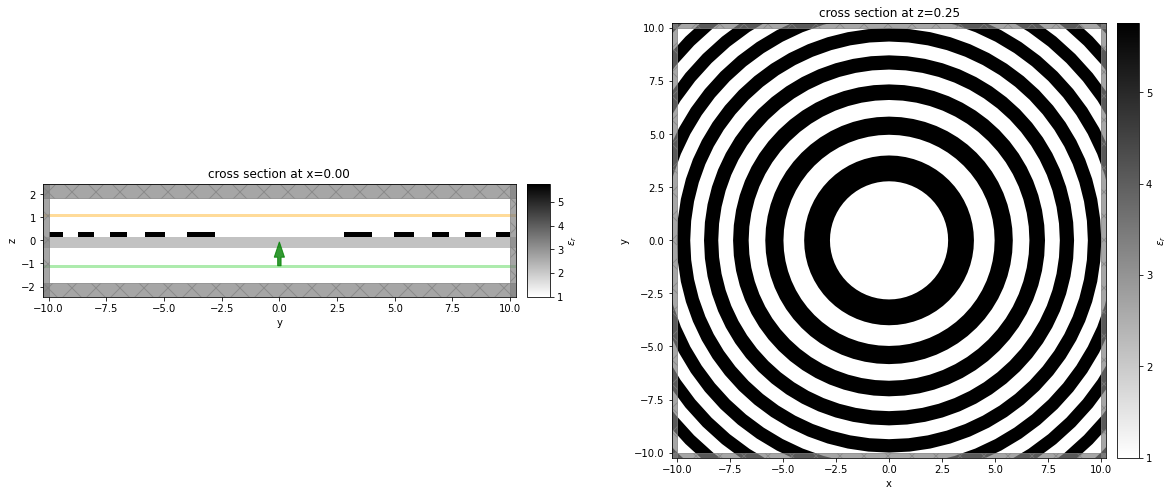

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
simulation.plot_eps(x=0, ax=ax1);
simulation.plot_eps(z=-length_z/2  + space_below_sub + height_sub + height_lens / 2, ax=ax2);

## Run Simulation

Now we can run the simulation and download the results


In [9]:
import tidy3d.web as web

sim_data = web.run(simulation, task_name='near2far', path='data/simulation.hdf5')

           INFO     Using Tidy3D credentials from stored file                      ]8;id=988812;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=832874;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#74\74]8;;\

[13:46:42] INFO     Uploaded task 'near2far' with task_id                       ]8;id=278788;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=950494;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '9135ea82-d0ca-48f0-8e1e-a867902834e7'.                                  

[13:46:48] INFO     status = queued                                             ]8;id=380462;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=568258;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[13:46:51] INFO     Maximum flex unit cost: 1.29                                ]8;id=790030;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=667240;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[13:46:53] INFO     status = preprocess                                         ]8;id=441845;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=53377;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[13:47:02] INFO     starting up solver                                          ]8;id=302357;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=602926;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[13:47:14] INFO     running solver                                              ]8;id=358009;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=714829;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

[13:48:12] INFO     early shutoff detected, exiting.                            ]8;id=387330;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=57413;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                        ]8;id=927811;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=205093;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#301\301]8;;\

Output()

[13:48:20] INFO     status = success                                            ]8;id=386597;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=772679;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[13:48:22] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=691168;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=120111;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#584\584]8;;\
                    "data/simulation.hdf5"                                                   

Output()

[13:49:14] INFO     loading SimulationData from data/simulation.hdf5            ]8;id=127324;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=133708;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#407\407]8;;\

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=79949;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=92305;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#314\314]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=601344;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=306510;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#314\314]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=246618;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=954318;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#314\314]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=724119;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=78544;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#314\314]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           INFO     Auto meshing using wavelength 1.0000 defined from        ]8;id=216222;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=960941;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#478\478]8;;\
                    sources.                                                                 

## Visualization 

Let's inspect the near field using the Tidy3D builtin field visualization methods.  
For more details see the documentation of [tidy3d.SimulationData](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.SimulationData.html#tidy3d-simulationdata).

<Figure size 1080x252 with 6 Axes>

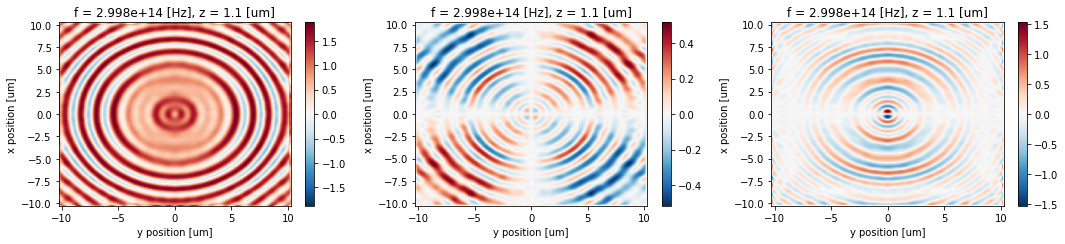

In [10]:
near_field_data = sim_data['nearfield']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))
near_field_data.Ex.interp(z=pos_monitor_z).real.plot(ax=ax1)
near_field_data.Ey.interp(z=pos_monitor_z).real.plot(ax=ax2)
near_field_data.Ez.interp(z=pos_monitor_z).real.plot(ax=ax3)
plt.show()

## Setting Up Near 2 Far

To set up near to far, we first need to grab the data from the nearfield monitor, for which we create a [Near2FarSurface](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Near2FarSurface.html) object to specify the monitor and its normal direction.

Then, we create a [Near2Far](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Near2Far.html) object using the monitor data as follows.
This object just stores near field data and provides [various methods](https://simulation.cloud/docs/html/generated/tidy3d.Near2Far.html#tidy3d.Near2Far) for looking at various far field quantities.

In [11]:
from tidy3d.plugins import Near2Far, Near2FarSurface

n2f_surface = Near2FarSurface(monitor=monitor_near, normal_dir='+')

n2f = Near2Far(
    sim_data=sim_data, 
    surfaces=[n2f_surface],  
    frequency=f0
)

## Getting Far Field Data

With the [Near2Far](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Near2Far.html) object initialized, we just need to call one of its methods to get a far field quantity.

For this example, we use `Near2Far.fields_cartesian(x,y,z)` to get the fields at a set of `x,y,z` points relative to the monitor center.

Below, we pass in an array of x and y points in a plane located at `z=z0` and record the far fields.

In [12]:
# points to project to
num_far = 40
xs_far = 4 * wavelength * np.linspace(-0.5, 0.5, num_far)
ys_far = 4 * wavelength * np.linspace(-0.5, 0.5, num_far)

far_fields = n2f.fields_cartesian(xs_far, ys_far, focal_length)

Output()

## Plot Results
Now we can plot the near and far fields together

<Figure size 720x360 with 12 Axes>

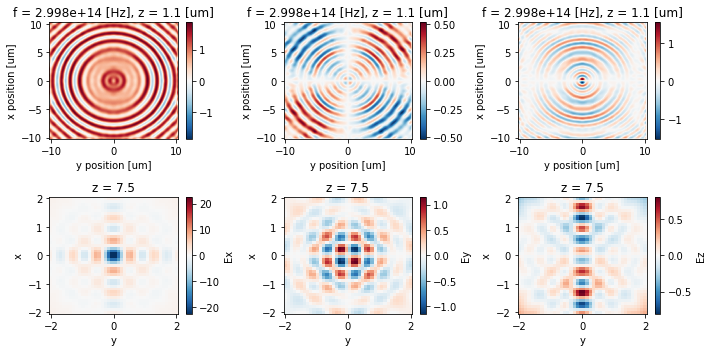

In [13]:
# plot everything
f, (axes_near, axes_far) =  plt.subplots(2, 3, tight_layout=True, figsize=(10, 5))

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

ax1, ax2, ax3 = axes_near
im = near_field_data.Ex.interp(z=pos_monitor_z).real.plot(ax=ax1)
im = near_field_data.Ey.interp(z=pos_monitor_z).real.plot(ax=ax2)
im = near_field_data.Ez.interp(z=pos_monitor_z).real.plot(ax=ax3)
# ax.set_title(f'near field E{direction}')

ax1, ax2, ax3 = axes_far
im = far_fields['Ex'].real.plot(ax=ax1)
im = far_fields['Ey'].real.plot(ax=ax2)
im = far_fields['Ez'].real.plot(ax=ax3)

plt.show()

We can also use the far field data and plot the field intensity to see the focusing effect.

<Figure size 720x360 with 4 Axes>

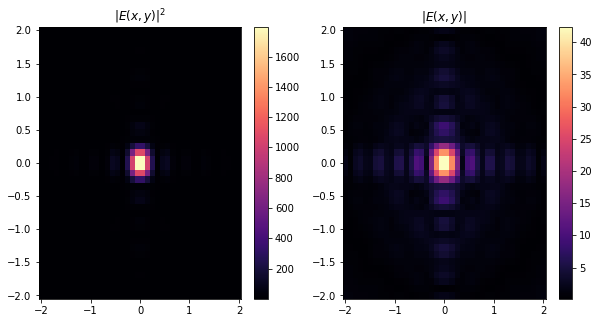

In [14]:
intensity_far = np.squeeze(
    np.square(np.abs(far_fields['Ex'].values)) +\
    np.square(np.abs(far_fields['Ey'].values)) +\
    np.square(np.abs(far_fields['Ez'].values))
)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = pmesh(xs_far, ys_far, intensity_far, ax=ax1, cmap='magma')
im2 = pmesh(xs_far, ys_far, np.sqrt(intensity_far), ax=ax2, cmap='magma')

ax1.set_title('$|E(x,y)|^2$')
ax2.set_title('$|E(x,y)|$')

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.show()